<a href="https://colab.research.google.com/github/sooo19/A-study-of-the-data-generation-model-of-the-Folk-Painting-source-data/blob/main/0318_Image%20Captioning%20with%20Folk%20Paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#22.03.18
#Image Caption -> ResNet, TransformerDecoder


https://www.kaggle.com/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch

1. Creating features for Images Using Resnet

2. Train Trnasformer Decoder Model which predicts next word given a sequence of tockens and Image Features from Step1

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random

pd.set_option('display.max_colwidth', None)

In [3]:
# read data
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images"
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/captions.txt",

df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/민화 caption dataset/메모장 작성_0318(1 keyword)/captions.txt", sep=',', encoding = 'utf-8')
print(len(df))
display(df.head(3)) # 데이터가 제대로 읽어와졌는지 확인하기 위해, 상위 3개 caption 출력.
display(df.tail(3))


7804


,image,caption
0,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .
1,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .
2,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .


,image,caption
7801,LSA00024.JPG,Painting as a Leisure Activity .
7802,LSA00024.JPG,Painting as a Leisure Activity .
7803,LSA00024.JPG,Painting as a Leisure Activity .


#데이터 전처리
Single Character(단일 문자), non alpha word 제거, 토큰과 ',' 추가.
모든 캡션의 최대 길이(max_seq_len)는 33으로 맞춰진다.


In [4]:
def remove_single_char_word(word_list):
  lst=[]
  for word in word_list:
    if len(word)>1:
      lst.append(word)
  return lst

In [5]:
# <start> < > < > ... < > <end> 형태로 캡션 저장 => 최대 길이: 9
df['cleaned_caption']=df['caption'].apply(lambda caption : ['<start>']+[word.lower() if word.isalpha() else '' for word in caption.split(" ")]+['<end>'])

# single character 제거
df['cleaned_caption']=df['cleaned_caption'].apply(lambda x:remove_single_char_word(x))

# seq_len에 길이 저장 => 9
df['seq_len']=df['cleaned_caption'].apply(lambda x:len(x))
max_seq_len=df['seq_len'].max()
print(max_seq_len)

9


In [6]:
df.drop(['seq_len'], axis = 1, inplace=True)
df['cleaned_caption']=df['cleaned_caption'].apply(lambda caption: caption+['<pad>']*(max_seq_len-len(caption)))

# 상위 3개 데이터 예시 출력
display(df.head(3))

,image,caption,cleaned_caption
0,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .,"[<start>, painting, of, tiger, mapie, and, pine, tree, <end>]"
1,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .,"[<start>, painting, of, tiger, mapie, and, pine, tree, <end>]"
2,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .,"[<start>, painting, of, tiger, mapie, and, pine, tree, <end>]"


# Create Vocab and mapping of token to ID

In [7]:
word_list=df['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')  
#join: , cat(concat): 문자열 합치기. sep=' '에 의해 한 칸씩 뛰고 저장이 된다.
word_dict=Counter(word_list)
word_dict=sorted(word_dict, key=word_dict.get, reverse=True)

print(len(word_dict))
print(word_dict[:20])

43
['<pad>', '<start>', 'painting', '<end>', 'of', 'and', 'flowers', 'birds', 'characters', 'books', 'stationery', 'buddhist', 'taoist', 'masters', 'mountains', 'rivers', 'peony', 'genre', 'tiger', 'mapie']


In [8]:
vocab_size=len(word_dict)
print(vocab_size)

index_to_word = {index: word for index, word in enumerate(word_dict)} #enumerate: 반복문에서 index값(몇번째 요소인지)을 출력
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

43
43 43


# Convert sequence of tokens to IDs

text_seq를 부여함. 단어별로 ID를 부여함.

In [9]:
df['text_seq']=df['cleaned_caption'].apply(lambda caption: [word_to_index[word] for word in caption])
display(df.head(3))

,image,caption,cleaned_caption,text_seq
0,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .,"[<start>, painting, of, tiger, mapie, and, pine, tree, <end>]","[1, 2, 4, 18, 19, 5, 20, 21, 3]"
1,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .,"[<start>, painting, of, tiger, mapie, and, pine, tree, <end>]","[1, 2, 4, 18, 19, 5, 20, 21, 3]"
2,TMP00001.JPG,Painting of Tiger Mapie and Pine Tree .,"[<start>, painting, of, tiger, mapie, and, pine, tree, <end>]","[1, 2, 4, 18, 19, 5, 20, 21, 3]"


# Split in Train and validation data. 
(Train과 validation data 나누기) 
한 데이터가 동시에 training, validation data가 될 수 없음.

In [10]:
df=df.sort_values(by='image')
train=df.iloc[:int(0.8*len(df))]  # train과 validation의 비율은 8:2
valid=df.iloc[int(0.8*len(df)):]

print(len(train), train['image'].nunique()) #nunique() : 데이터에 고유값들의 수를 출력, 즉 중복되는 않은 순 단어의 개수 세기
print(len(valid), valid['image'].nunique())

6243 1249
1561 313


# Extract features from Images Using Resnet
Restnet 구조를 통해 feature 추출

In [11]:
train_samples=len(train)
print(train_samples)  # train 길이 출력

unq_train_imgs=train[['image']].drop_duplicates() #중복되는 이미지 제거
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

6243
1249 313


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 로컬에서 돌려보기 (cpu로)
print(device) #Cuda 사용

cuda


### 이미지를 읽어올때 가운데를 중심으로 정사각형으로 오려낸 다음 224, 224로 크기를 변경하는 코드

In [42]:
class extractImageFeatureResNetDataSet(): # Resnet 구조를 이용해 이미지의 feature 값들을 추출
  def __init__(self, data):
    self.data=data    
    self.scaler=transforms.Resize([224, 224]) # 이미지 크기 재정의
    
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.to_tensor=transforms.ToTensor()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name=self.data.iloc[idx]['image']
    print(image_name) #image 이름 출력
    #img_loc="/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0314_Folk Dataset(5 keywords)_Captioning/images/" + str(image_name)
    img_loc="/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0314_Folk Dataset(5 keywords)_Captioning/images/"+ str(image_name)
    img=Image.open(img_loc)
    width, height = img.size   # Get dimensions
    new_size = min(width, height)
    left   = (width  - new_size)/2
    top    = (height - new_size)/2
    right  = (width  + new_size)/2
    bottom = (height + new_size)/2
    img = img.crop((left, top, right, bottom))
    print(img.size) #image size 출력
    t_img=self.normalize(self.to_tensor(self.scaler(img)))
    return image_name, t_img

In [14]:
# 기존 코드
# class extractImageFeatureResNetDataSet(): # Resnet 구조를 이용해 이미지의 feature 값들을 추출
#   def __init__(self, data):
#     self.data=data
#     self.scaler=transforms.Resize([224, 224]) # 이미지 크기 재정의
#     self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     self.to_tensor=transforms.ToTensor()

#   def __len__(self):
#     return len(self.data)

#   def __getitem__(self, idx):
#     image_name=self.data.iloc[idx]['image']
#     print(str(image_name))
#     img_loc="/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0314_Folk Dataset(5 keywords)_Captioning/images/" + str(image_name)
#     img=Image.open(img_loc)
#     t_img=self.normalize(self.to_tensor(self.scaler(img)))
#     return image_name, t_img

In [15]:
from torchvision import transforms

In [16]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)  # train 이미지들의 feature를 추출해 저장
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size=1, shuffle=True) # true로 수정, batch size도 클수록 효과가 좋아짐 (2^n 단위로 키우기)

valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)  # validation 이미지들의 feature를 추출해 저장
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=True)

In [17]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [18]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [19]:
def get_vector(t_img):
  t_img = Variable(t_img)
  my_embedding = torch.zeros(1, 512, 7, 7)  # torch.zeros : 0으로 채워진 텐서 생성
  def copy_data(m, i, o):
    my_embedding.copy_(o.data)

  h = resNet18Layer4.register_forward_hook(copy_data)
  resnet18(t_img)

  h.remove()
  return my_embedding

In [20]:
#print("/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/1000268201_693b08cb0e.jpg")

In [21]:
'''
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0226_Folk Dataset_ImageCaptioning/dataset_complete/images/DCM00003-1.jpg')
plt.imshow(image)
plt.show()
'''
# 엔터가 정확히 쳐졌는지, 하나씩 출력해보면서 확인 (사진 이름 리스트 출력해보기)
# 파일 이름 제대로 출력되는지 출력해보기

"\nimport matplotlib.pyplot as plt\nimport matplotlib.image as img\n\nimage = img.imread('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0226_Folk Dataset_ImageCaptioning/dataset_complete/images/DCM00003-1.jpg')\nplt.imshow(image)\nplt.show()\n"

In [22]:
extract_imgFtr_ResNet_train = {}  # train 이미지들의 feature 추출
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):   # tqdm: 진행률 프로그래스바
  t_img = t_img.to(device)
  embdg = get_vector(t_img)

  extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/1249 [00:00<?, ?it/s]

FNB00144.JPG
(196, 196)
GNR00014.JPG
(207, 206)
FNB00154.JPG
(481, 481)
LGF00029.JPG
(331, 331)
FNB00159.JPG
(238, 238)
LGF00042.JPG
(515, 514)
CHR00091.JPG
(461, 461)
GNR00006.JPG
(230, 230)
BNS00041.JPG
(576, 576)
BTM00078.JPG
(435, 435)
LGF00017-2.JPG
(535, 535)
CHR00146.JPG
(341, 341)
BTM00031.JPG
(256, 256)
CHR00131.JPG
(474, 474)
GNR00061.JPG
(430, 430)
BNS00075.JPG
(338, 338)
GNR00062.JPG
(255, 255)
BNS00115.JPG
(489, 489)
LTS00017.JPG
(356, 356)
BNS00009.JPG
(248, 248)
FNB00066.JPG
(200, 200)
HNS00012-4.JPG
(631, 631)
CHR00107.JPG
(343, 343)
FNB00202.JPG
(314, 314)
GNR00041.JPG
(244, 244)
FNB00026.JPG
(284, 284)
MNR00005.JPG
(228, 228)
BNS00014.JPG
(234, 234)
FNV00004.JPG
(385, 384)
CHR00148.JPG
(492, 492)
DCM00031.JPG
(230, 230)
BNS00106.JPG
(409, 409)
CHR00188.JPG
(546, 546)
CHR00084.JPG
(467, 466)
FNB00019.JPG
(309, 309)
BTM00100.JPG
(574, 574)
FNB00192.JPG
(259, 259)
BNS00058.JPG
(470, 470)
BNS00125-1.JPG
(465, 465)
GNR00073.JPG
(370, 370)
FNB00184.JPG
(448, 448)
FSH00058.J

In [23]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [24]:
#t_image = Image.open(image_name).convert('RGB')

In [25]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
  t_img = t_img.to(device)
  embdg = get_vector(t_img)
  extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/313 [00:00<?, ?it/s]

TMP00062.JPG
(596, 596)
TSL00020.JPG
(196, 196)
PNY00030.JPG
(236, 236)
PNY00074.JPG
(379, 380)
PNY00044.JPG
(224, 224)
TSL00019.JPG
(188, 188)
TSL00054-1.JPG
(429, 429)
PNY00014.JPG
(231, 232)
MNR00111.JPG
(470, 470)
TSL00031.JPG
(404, 404)
PNY00038.JPG
(234, 234)
PNY00041.JPG
(234, 234)
TMP00060.JPG
(502, 502)
TSL00052-1.JPG
(612, 612)
TMP00072.JPG
(622, 622)
PNY00046.JPG
(241, 242)
MNR00049.JPG
(431, 431)
PNY00043.JPG
(213, 213)
TMP00039.JPG
(361, 360)
MNR00046.JPG
(394, 394)
MNR00080.JPG
(212, 212)
TMP00037.JPG
(359, 359)
MNR00047.JPG
(401, 401)
TMP00001.JPG
(246, 246)
PNY00072.JPG
(477, 477)
PNY00002.JPG
(198, 198)
MNR00072.JPG
(372, 372)
MNR00098.JPG
(576, 576)
TMP00042.JPG
(377, 378)
TMP00027.JPG
(415, 414)
PNY00047.JPG
(227, 227)
TMP00073.JPG
(643, 643)
PNY00003.JPG
(240, 240)
PNY00061.JPG
(370, 370)
MNR00069.JPG
(376, 376)
PNY00073.JPG
(367, 366)
MNR00078.JPG
(212, 212)
MNR00091.JPG
(545, 546)
TSL00037.JPG
(249, 249)
MNR00101.JPG
(263, 262)
PNY00066.JPG
(262, 262)
TSL00056.JPG

In [26]:
a_file=open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

#Create DataLoader which will be used to load data into Transformer Model
Transformer 모델에 데이터를 load하는데 사용할 dataloader을 생성

(FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.)

In [27]:
global image_tensor_view

class FlickerDataSetResnet():
  def __init__(self, data, pkl_file):
    self.data=data
    self.encodedImgs = pd.read_pickle(pkl_file)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    caption_seq = self.data.iloc[idx]['text_seq']
    target_seq = caption_seq[1:]+[0]

    image_name = self.data.iloc[idx]['image']
    image_tensor = self.encodedImgs[image_name]
    image_tensor = image_tensor.permute(0,2,3,1)  # tensor의 모양을 변환. permute는 모든 차원을 교환할 수 있음.
    image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))
    return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [28]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [29]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle = True)

#Create Transformer Decoder Model
This model will take caption sequence and the extracted resnet image features as input and output 1 timestep shifted caption sequence.

In the Transformer decoder, lookAhead and padding mask has also been applied

In [30]:
# Position Embedding

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [31]:
# Image Captioning Model
# Transformer Decoder

class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

#Train the Model

The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [32]:
#EPOCH = 300
#EPOCH = 150
EPOCH = 300

In [33]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose=True)
criterion=torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss=np.float('Inf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [34]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  1.16100013256073 Eval Loss ->  2.564007043838501
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  0.3032563328742981 Eval Loss ->  2.538207530975342
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  0.2048935443162918 Eval Loss ->  2.5411670207977295
Epoch ->  3  Training Loss ->  0.15549828112125397 Eval Loss ->  2.5784523487091064
Epoch ->  4  Training Loss ->  0.12250454723834991 Eval Loss ->  2.592559337615967
Epoch     5: reducing learning rate of group 0 to 8.0000e-06.
Epoch ->  5  Training Loss ->  0.09792237728834152 Eval Loss ->  2.629817008972168
Epoch ->  6  Training Loss ->  0.07898949831724167 Eval Loss ->  2.6569762229919434
Epoch ->  7  Training Loss ->  0.0649431124329567 Eval Loss ->  2.691861152648926
Epoch     8: reducing learning rate of group 0 to 6.4000e-06.
Epoch ->  8  Training Loss ->  0.05150104686617851 Eval Loss ->  2.6898515224456787
Epoch ->  9  Training Loss ->  0.04310426115989685 Eval Loss ->  2.677660942077

#Generate Captions

In [35]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 9  # 캡션의 max length
print(start_token, end_token, pad_token)

1 3 0


In [36]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [94]:
result_predicted_sentece=[] #정확도(캡션의 정답률) 측정을 위해 결과 값을 배열에 따로 저장함 (이미지 번호, 정답캡션, 예측된 캡션)

def generate_caption(K, img_nm): 
    img_loc = '/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0314_Folk Dataset(5 keywords)_Captioning/images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]    #valid_img_df: 각 단어를 가중치 값으로(단어마다의 고유 값) 나열
    print(img_nm)
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
            result_predicted_sentece.append(img_nm)   #이미지 번호, 정답 캡션, 예측 캡션
            result_predicted_sentece.append(valid_img_df['caption'].tolist())
            result_predicted_sentece.append(predicted_sentence)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

#Test print (Validation)
###예측 결과 출력 및 저장


##한 장씩 출력

MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


MNR00015.JPG
Actual Caption : 
['Paintin

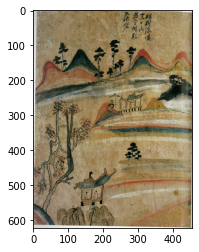

In [65]:
for i in range(1, 10):
    generate_caption(1, unq_valid_imgs.iloc[0]['image'])
    print("\n")

MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']


Predicted caption : 
painting of legendary figures .


MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']


Predicted caption : 
painting of legendary figures .


MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']


Predicted caption : 
painting of legendary figures .


MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Moun

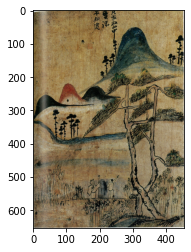

In [61]:
for i in range(1, 10):
    generate_caption(1, unq_valid_imgs.iloc[1]['image'])
    print("\n")

##10장씩 출력

1 번.

1 ) 
MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']


Predicted caption : 
painting of legendary figures .


2 ) 
MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']


Predicted caption : 
painting of legendary figures .


3 ) 
MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']


Predicted caption : 
painting of legendary figures .


4 ) 
MNR00016.JPG
Actual Caption : 
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Ri

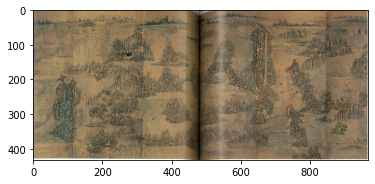

In [89]:
for j in range(1, 11):
  print(j,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [90]:
#print(result_predicted_sentece)
for val in result_predicted_sentece:
  print(val)


MNR00016.JPG
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'legendary', 'figures']
MNR00016.JPG
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'legendary', 'figures']
MNR00016.JPG
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'legendary', 'figures']
MNR00016.JPG
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'legendary', 'figures']
MNR00016.JPG

##validation dataset 전체에 대한 prediction caption 생성 및 출력
###50장 단위씩 출력

In [95]:
# 정답 배열 초기화
result_predicted_sentece=[] #정확도(캡션의 정답률) 측정을 위해 결과 값을 배열에 따로 저장함 (이미지 번호, 정답캡션, 예측된 캡션)

1 번.

1 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


2 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


3 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


4 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


5 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


6 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


7 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of characters .


8 ) 
MNR00015.JPG
Actual Caption : 
['Painting of Mountains and Rivers .']


Predicted caption : 
painting of character

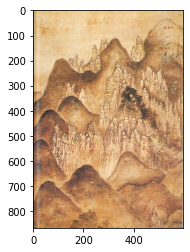

In [96]:
for j in range(0, 49):
  print(j+1,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [97]:
for val in result_predicted_sentece:
  print(val)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'flowers', 'and', 'birds']
MNR00020.JPG
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'flowers', 'and', 'birds']
MNR00020.JPG
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'flowers', 'and', 'birds']
MNR00020.JPG
['Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .', 'Painting of Mountains and Rivers .']
['painting', 'of', 'flo

In [ ]:
for j in range(49, 99):
  print(j+1,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [ ]:
for val in result_predicted_sentece:
  print(val)


In [ ]:
for j in range(99, 149):
  print(j+1,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [ ]:
for val in result_predicted_sentece:
  print(val)


In [ ]:
for j in range(149, 199):
  print(j+1,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [ ]:
for val in result_predicted_sentece:
  print(val)


In [ ]:
for j in range(199, 249):
  print(j+1,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [ ]:
for val in result_predicted_sentece:
  print(val)


In [ ]:
for j in range(249, 299):
  print(j+1,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [ ]:
for val in result_predicted_sentece:
  print(val)


In [ ]:
for j in range(299, 313):
  print(j+1,"번.\n")
  for i in range(1, 11):
    print(i,') ')
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])
    print("\n")

In [ ]:
for val in result_predicted_sentece:
  print(val)


###예측 캡션을 전부 generate하여 배열에 저장하고, 한번에 txt 파일로 저장

In [103]:
# 정답 배열 초기화
result_predicted_sentece=[] #정확도(캡션의 정답률) 측정을 위해 결과 값을 배열에 따로 저장함 (이미지 번호, 정답캡션, 예측된 캡션)

In [100]:
def generate_caption(K, img_nm): 
    img_loc = '/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0314_Folk Dataset(5 keywords)_Captioning/images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]    #valid_img_df: 각 단어를 가중치 값으로(단어마다의 고유 값) 나열
    # print(img_nm)
    # print("Actual Caption : ")
    # print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
            result_predicted_sentece.append(img_nm)   #이미지 번호, 정답 캡션, 예측 캡션
            result_predicted_sentece.append(valid_img_df['caption'].tolist())
            result_predicted_sentece.append(predicted_sentence)
            result_predicted_sentece.append('\n')
    # print("\n")
    # print("Predicted caption : ")
    # print(" ".join(predicted_sentence+['.']))

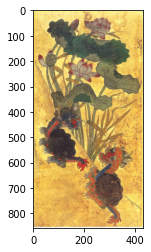

In [101]:
for j in range(0, 300):
  for i in range(1, 11):
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])

In [102]:
# 결과를 csv 파일에 저장
import pandas as pd 
import numpy as np

pd.DataFrame(result_predicted_sentece).to_csv('result.csv')   # 이미지 번호, 정답 캡션, 예측 캡션 결과를 csv 파일에 저장

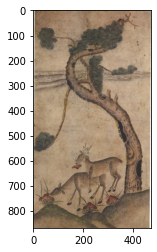

In [104]:
for j in range(300, 313): # validation dataset이 총 313장 존재
  for i in range(1, 11):
    generate_caption(1, unq_valid_imgs.iloc[j]['image'])

In [105]:
# 결과를 csv 파일에 저장
import pandas as pd 
import numpy as np

pd.DataFrame(result_predicted_sentece).to_csv('result2.csv')